# Playing Around and Creating my Own VeloGames API
- cleansed data
- merged data for team comparison
- create web scraper for gathering stage data daily from this [website](https://www.letour.fr/en/stage-14)

In [6]:
# Make sure your local files are here
#ls
pd.set_option('display.max_columns', None)

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load the CSV file into a pandas DataFrame
tdf_stage_stats = pd.read_csv('tdf_stats.csv')

In [8]:
def clean_column_nans(column_series):
    """
    Moves all non-null values in a Series to the top, preserving their order,
    and fills the rest with NaN values. The length of the Series remains the same.
    """
    # 1. Get all non-null values from the column
    non_null_values = column_series.dropna()
    
    # 2. Calculate how many NaNs need to be appended to fill the original length
    num_nans_to_add = len(column_series) - len(non_null_values)
    
    # 3. Create a Series of NaNs of the required length
    # It's important to use the same dtype as the original series for consistency
    nans_to_append = pd.Series([np.nan] * num_nans_to_add, dtype=column_series.dtype)
    
    # 4. Concatenate the non-nulls with the appended NaNs
    # ignore_index=True ensures a clean new index from 0 to len(column_series)-1
    cleaned_series = pd.concat([non_null_values, nans_to_append], ignore_index=True)
    
    return cleaned_series

def process_raw_stage_column(stage_series):
    """
    Transforms a single pandas Series (representing a raw stage column)
    into a DataFrame with 'Points', 'Rider', and 'Team' columns.
    Handles 'number points' format, missing values, and incomplete blocks.

    Args:
        stage_series (pd.Series): A Series from the original DataFrame,
                                  containing interleaved points strings, rider names,
                                  and team names, possibly with NaN values.

    Returns:
        pd.DataFrame: A structured DataFrame with 3 columns for the stage data.
    """
    # Drop any NaN values as they indicate empty rows in the sequence
    # and convert to string to ensure consistent processing for regex
    data_list = stage_series.dropna().astype(str).tolist()

    points_list = []
    rider_list = []
    team_list = []

    # Iterate through the data list with a step of 3
    for i in range(0, len(data_list), 3):
        try:
            points_str = data_list[i]
            rider_name = data_list[i+1]
            team_name = data_list[i+2]

            # Extract the numeric part from the points string
            # Using pd.Series().str.extract handles cases where the string might not match
            # It will return NaN if no number is found, which is then converted to pd.NA
            points_numeric = pd.Series([points_str]).str.extract(r'(\d+)\s*points').iloc[0, 0]

            points_list.append(points_numeric)
            rider_list.append(rider_name)
            team_list.append(team_name)
        except IndexError:
            # This handles cases where the data list isn't a perfect multiple of 3
            # (e.g., missing a rider or team at the very end of the column)
            print(f"Warning: Incomplete data block found at index {i}. Skipping remaining entries.")
            break # Exit the loop as the sequence is broken
        except Exception as e:
            # Handles unexpected formats in the 'points_str' or other issues
            print(f"Warning: Error processing data at index {i}: {e}. Appending NA.")
            points_list.append(pd.NA)
            rider_list.append(pd.NA)
            team_list.append(pd.NA)

    # Create the structured DataFrame for this single stage
    df_structured_stage = pd.DataFrame({
        'Points': points_list,
        'Rider': rider_list,
        'Team': team_list
    })

    # Convert 'Points' column to numeric, coercing errors to NaN, then to nullable integer
    df_structured_stage['Points'] = pd.to_numeric(df_structured_stage['Points'], errors='coerce').astype('Int64')

    return df_structured_stage

In [9]:
# List to store the structured DataFrame for each stage
structured_stage_dfs = []

# Iterate through each column of the raw data DataFrame
for col_name in tdf_stage_stats.columns:
    print(f"Processing column: '{col_name}'...")
    
    # Process the current stage column using our defined function
    df_current_stage = process_raw_stage_column(tdf_stage_stats[col_name])
    
    # Rename the columns to be specific to this stage (e.g., 'Stage 1 Points')
    df_current_stage.columns = [
        f"{col_name} Points",
        f"{col_name} Rider",
        f"{col_name} Team"
    ]
    
    structured_stage_dfs.append(df_current_stage)

# Concatenate all the structured stage DataFrames horizontally (axis=1)
final_manipulation_df = pd.concat(structured_stage_dfs, axis=1)

print("\n" + "="*40 + "\n")
print("--- Final Combined DataFrame for Manipulation ---")
print(final_manipulation_df)

Processing column: 'Stage 1 '...
Processing column: 'Stage 2'...
Processing column: 'Stage 3'...
Processing column: 'Stage 4'...
Processing column: 'Stage 5'...
Processing column: 'Stage 6'...
Processing column: 'Stage 7'...
Processing column: 'Stage 8'...
Processing column: 'Stage 9'...
Processing column: 'Stage 10'...
Processing column: 'Stage 11'...
Processing column: 'Stage 12'...
Processing column: 'Stage 13'...
Processing column: 'Stage 14'...
Processing column: 'Stage 15'...
Processing column: 'Stage 16'...
Processing column: 'Stage 17'...
Processing column: 'Stage 18'...
Processing column: 'Stage 19'...
Processing column: 'Stage 20'...
Processing column: 'Stage 21'...


--- Final Combined DataFrame for Manipulation ---
    Stage 1  Points     Stage 1  Rider           Stage 1  Team  \
0               272   Jasper Philipsen    Alpecin - Deceuninck   
1               226      Biniam Girmay     Intermarché - Wanty   
2               183  Søren Wærenskjold          Uno-X Mobility   

In [10]:
final_manipulation_df

,Stage 1 Points,Stage 1 Rider,Stage 1 Team,Stage 2 Points,Stage 2 Rider,Stage 2 Team,Stage 3 Points,Stage 3 Rider,Stage 3 Team,Stage 4 Points,Stage 4 Rider,Stage 4 Team,Stage 5 Points,Stage 5 Rider,Stage 5 Team,Stage 6 Points,Stage 6 Rider,Stage 6 Team,Stage 7 Points,Stage 7 Rider,Stage 7 Team,Stage 8 Points,Stage 8 Rider,Stage 8 Team,Stage 9 Points,Stage 9 Rider,Stage 9 Team,Stage 10 Points,Stage 10 Rider,Stage 10 Team,Stage 11 Points,Stage 11 Rider,Stage 11 Team,Stage 12 Points,Stage 12 Rider,Stage 12 Team,Stage 13 Points,Stage 13 Rider,Stage 13 Team,Stage 14 Points,Stage 14 Rider,Stage 14 Team,Stage 15 Points,Stage 15 Rider,Stage 15 Team,Stage 16 Points,Stage 16 Rider,Stage 16 Team,Stage 17 Points,Stage 17 Rider,Stage 17 Team,Stage 18 Points,Stage 18 Rider,Stage 18 Team,Stage 19 Points,Stage 19 Rider,Stage 19 Team,Stage 20 Points,Stage 20 Rider,Stage 20 Team,Stage 21 Points,Stage 21 Rider,Stage 21 Team
0,272,Jasper Philipsen,Alpecin - Deceuninck,258,Mathieu Van Der Poel,Alpecin - Deceuninck,226,Tim Merlier,Soudal Quick-Step,264,Tadej Pogačar,UAE Team Emirates - XRG,246,Remco Evenepoel,Soudal Quick-Step,264,Ben Healy,EF Education - EasyPost,274,Tadej Pogačar,UAE Team Emirates - XRG,252,Jonathan Milan,Lidl - Trek,234,Tim Merlier,Soudal Quick-Step,248,Simon Yates,Team Visma | Lease a Bike,260,Jonas Abrahamsen,Uno-X Mobility,304,Tadej Pogačar,UAE Team Emirates - XRG,270,Tadej Pogačar,UAE Team Emirates - XRG,292,Thymen Arensman,INEOS Grenadiers,252,Tim Wellens,UAE Team Emirates - XRG,251,Valentin Paret-Peintre,Soudal Quick-Step,238,Jonathan Milan,Lidl - Trek,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
1,226,Biniam Girmay,Intermarché - Wanty,219,Tadej Pogačar,UAE Team Emirates - XRG,212,Jonathan Milan,Lidl - Trek,216,Mathieu Van Der Poel,Alpecin - Deceuninck,234,Tadej Pogačar,UAE Team Emirates - XRG,206,Quinn Simmons,Lidl - Trek,212,Jonas Vingegaard,Team Visma | Lease a Bike,188,Wout Van Aert,Team Visma | Lease a Bike,204,Jonathan Milan,Lidl - Trek,218,Ben Healy,EF Education - EasyPost,212,Mauro Schmid,Team Jayco AlUla,243,Jonas Vingegaard,Team Visma | Lease a Bike,213,Jonas Vingegaard,Team Visma | Lease a Bike,255,Tadej Pogačar,UAE Team Emirates - XRG,216,Victor Campenaerts,Team Visma | Lease a Bike,217,Ben Healy,EF Education - EasyPost,184,Jordi Meeus,Red Bull - BORA - hansgrohe,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
2,183,Søren Wærenskjold,Uno-X Mobility,190,Jonas Vingegaard,Team Visma | Lease a Bike,160,Phil Bauhaus,Bahrain - Victorious,196,Jonas Vingegaard,Team Visma | Lease a Bike,160,Edoardo Affini,Team Visma | Lease a Bike,182,Michael Storer,Tudor Pro Cycling Team,174,Oscar Onley,Team Picnic PostNL,160,Kaden Groves,Alpecin - Deceuninck,162,Arnaud De Lie,Lotto,204,Thymen Arensman,INEOS Grenadiers,169,Mathieu Van Der Poel,Alpecin - Deceuninck,198,Florian Lipowitz,Red Bull - BORA - hansgrohe,174,Primož Roglič,Red Bull - BORA - hansgrohe,219,Jonas Vingegaard,Team Visma | Lease a Bike,160,Julian Alaphilippe,Tudor Pro Cycling Team,184,Tadej Pogačar,UAE Team Emirates - XRG,160,Tobias Lund Andresen,Team Picnic PostNL,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
3,170,Anthony Turgis,Team TotalEnergies,148,Romain Grégoire,Groupama - FDJ,144,Søren Wærenskjold,Uno-X Mobility,154,Oscar Onley,Team Picnic PostNL,143,Kévin Vauquelin,Arkéa - B&B Hotels,164,Eddie Dunbar,Team Jayco AlUla,147,Felix Gall,Decathlon AG2R La Mondiale Team,140,Pascal Ackermann,Israel - Premier Tech,140,Pavel Bittner,Team Picnic PostNL,163,Ben O'Connor,Team Jayco AlUla,144,Arnaud De Lie,Lotto,168,Tobias Halland Johannessen,Uno-X Mobility,159,Florian Lipowitz,Red Bull - BORA - hansgrohe,171,Felix Gall,Decathlon AG2R La Mondiale Team,156,Wout Van Aert,Team Visma | Lease a Bike,180,Santiago Buitrago,Bahrain - Victorious,140,Arnaud De Lie,Lotto,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
4,144,Matteo Trentin,Tudor Pro Cycling Team,120,Julian Alaphilippe,Tudor Pro Cycling Team,122,Biniam Girmay,Intermarché - Wanty,137,João Almeida,UA

In [16]:
# Clean up column names in stage data
final_manipulation_df.columns = final_manipulation_df.columns.str.strip().str.replace(r'\s+', ' ', regex=True)

# Function to calculate cumulative points for a rider
def calculate_cumulative_points(rider_name, stages=17):
    rider_points = []
    for stage in range(1, stages + 1):  # First `stages` stages
        stage_points_col = f"Stage {stage} Points"
        stage_rider_col = f"Stage {stage} Rider"

        # Check if the columns exist
        if stage_points_col in stage_data.columns and stage_rider_col in stage_data.columns:
            stage_points = stage_data.loc[stage_data[stage_rider_col].str.contains(rider_name, na=False, case=False), stage_points_col]
            if not stage_points.empty:
                rider_points.append(stage_points.values[0])
            else:
                rider_points.append(0)
        else:
            print(f"Columns '{stage_points_col}' or '{stage_rider_col}' not found!")
            rider_points.append(0)

    # Calculate cumulative points
    cumulative_points = [sum(rider_points[:i + 1]) for i in range(len(rider_points))]
    return cumulative_points

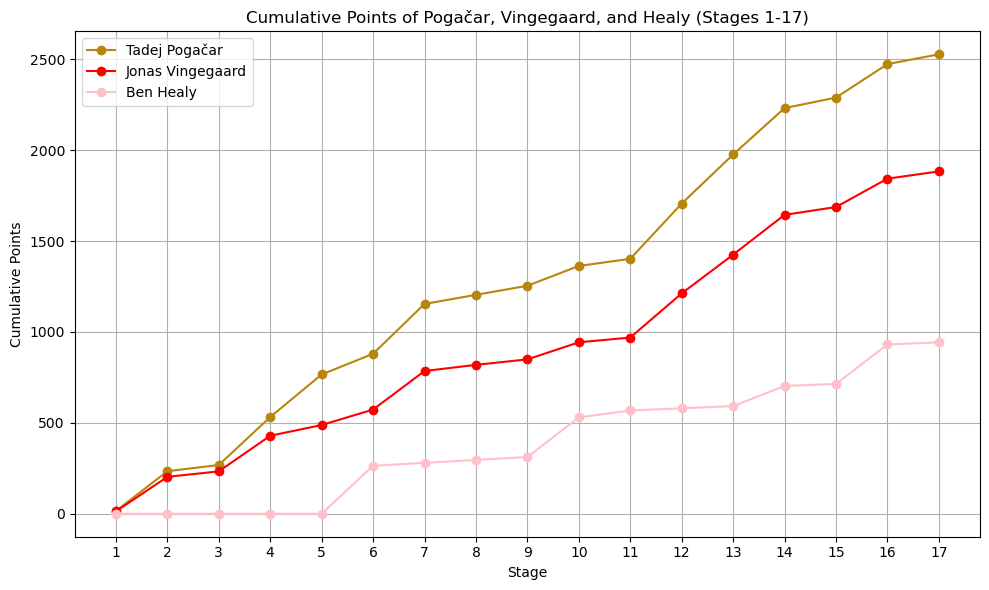

In [17]:
# Calculate cumulative points for Pogačar, Vingegaard, and Healy
pogacar_points = calculate_cumulative_points("Pogačar")
vingegaard_points = calculate_cumulative_points("Vingegaard")
healy_points = calculate_cumulative_points("Healy")

# Plot the cumulative points
plt.figure(figsize=(10, 6))
plt.plot(range(1, 18), pogacar_points, marker='o', label="Tadej Pogačar", color='darkgoldenrod')
plt.plot(range(1, 18), vingegaard_points, marker='o', label="Jonas Vingegaard", color='red')
plt.plot(range(1, 18), healy_points, marker='o', label="Ben Healy", color='pink')

# Add titles and labels
plt.title("Cumulative Points of Pogačar, Vingegaard, and Healy (Stages 1-17)")
plt.xlabel("Stage")
plt.ylabel("Cumulative Points")
plt.xticks(range(1, 18))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Load the data
stage_data = final_manipulation_df
team_info = pd.read_csv('team_info.csv', header=None)

# Extract team and rider information
teams = team_info.iloc[0].tolist()
team_riders = {team: team_info.iloc[1:, idx].dropna().str.strip().tolist() for idx, team in enumerate(teams)}

# Initialize a dictionary to store cumulative points for each team
team_cumulative_points = {team: [0] * 18 for team in teams}

In [14]:
# Loop through each team and calculate cumulative points
for team, riders in team_riders.items():
    # Initialize cumulative points for this team
    cumulative_points = [0] * 18

    # Loop through each rider on the team
    for rider in riders:
        rider_points = []
        for stage in range(1, 18):  # First 17 stages
            stage_points_col = f"Stage {stage} Points"
            stage_rider_col = f"Stage {stage} Rider"

            # Check if the rider scored points in this stage
            stage_points = stage_data.loc[stage_data[stage_rider_col].str.contains(rider, na=False, case=False), stage_points_col]
            if not stage_points.empty:
                rider_points.append(stage_points.values[0])
            else:
                rider_points.append(0)

        # Add the rider's cumulative points to the team's cumulative points
        cumulative_points = [cumulative_points[i] + sum(rider_points[:i + 1]) for i in range(17)]

    # Store the team's cumulative points
    team_cumulative_points[team] = cumulative_points

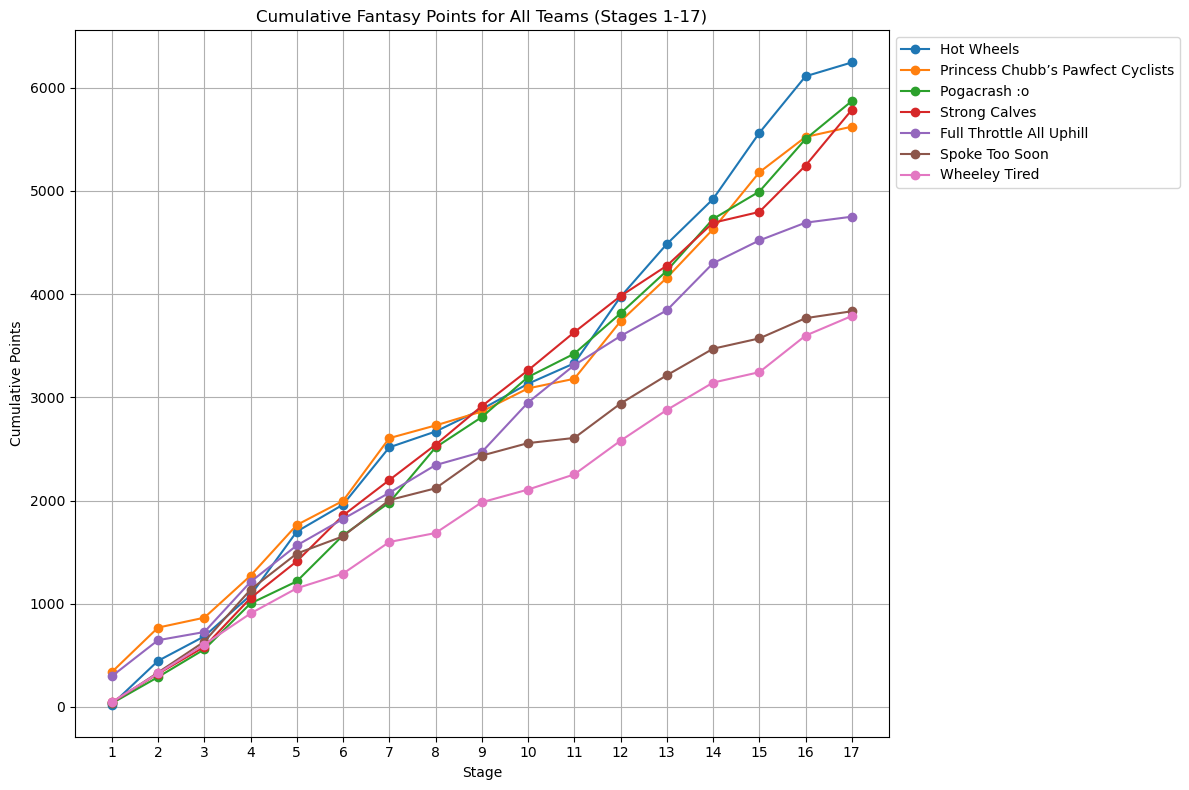

In [15]:
# Plot the cumulative points for all teams
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10.colors  # Use a colormap for distinct colors
for idx, (team, points) in enumerate(team_cumulative_points.items()):
    plt.plot(range(1, 18), points, marker='o', label=team, color=colors[idx % len(colors)])

plt.title("Cumulative Fantasy Points for All Teams (Stages 1-17)")
plt.xlabel("Stage")
plt.ylabel("Cumulative Points")
plt.xticks(range(1, 18))
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.tight_layout()
plt.show()

In [18]:
fantasy_teams = pd.read_csv('team_info.csv')
fantasy_teams

,Hot Wheels,Princess Chubb’s Pawfect Cyclists,Pogacrash :o,Strong Calves,Full Throttle All Uphill,Spoke Too Soon,Wheeley Tired
0,Pogačar,Pogačar,Vingegaard,Pogačar,Evenepoel,Pogačar,A Yates
1,Evenepoel,Evenepoel,Almeida,Almeida,Roglič,Almeida,Van Eetvelt
2,Buitrago,Kuss,Kuss,Champoussin,O'Connor,Skjelmose,Mas
3,Alaphilippe,Alaphilippe,Healy,Healy,Skjelmose,L Martinez,C Rodríguez
4,Bauhaus,Philipsen,Milan,Meeus,Philipsen,Merlier,Merlier
5,Wellens,Eenkhoorn,Van Aert,Abrahamsen,Van Der Poel,Nys,Ballerini
6,Buchmann,Märkl,Van Dijke,Politt,Van Aert,Barthe,Nys
7,Laurance,Wellens,Theuns,Ganna,Barré,De Buyst,Mühlberger
8,Lipowitz,Gall,Roglič,Milan,Arensman,Dillier,Pogačar


# Matching Rider Points to Fantasy Team

In [50]:
def transform_rider_data_to_columns(df_single_column, source_column_name='Data'):
    """
    Transforms a single-column DataFrame containing repeating rider data
    (points string, rider name, team name) into a three-column DataFrame.

    Args:
        df_single_column (pd.DataFrame): A DataFrame with a single column
                                         where data is structured as:
                                         Row 0, 3, 6...: Rider Points (e.g., "150 points")
                                         Row 1, 4, 7...: Rider Name
                                         Row 2, 5, 8...: Rider Team
        source_column_name (str): The name of the single column in the input DataFrame.

    Returns:
        pd.DataFrame: A new DataFrame with 'Points', 'Rider Name', and 'Team' columns.
    """
    # Ensure the input is a DataFrame and has the specified source column
    if not isinstance(df_single_column, pd.DataFrame) or source_column_name not in df_single_column.columns:
        raise ValueError(f"Input must be a pandas DataFrame with a column named '{source_column_name}'.")

    # Get the data from the single column as a list for easier indexing
    data_list = df_single_column[source_column_name].astype(str).tolist()

    extracted_points = []
    rider_names = []
    teams = []

    # Iterate through the data_list with a step of 3
    # This loop correctly picks out each piece of information based on its position
    for i in range(0, len(data_list), 3):
        try:
            # Extract the points string (e.g., "150 points")
            points_str = data_list[i]
            # Extract the rider name
            name = data_list[i+1]
            # Extract the team name
            team = data_list[i+2]

            # Use regex to get just the number from the points string
            # This handles "150 points" -> "150"
            points_numeric_str = pd.Series([points_str]).str.extract(r'(\d+)\s*points').iloc[0, 0]

            extracted_points.append(points_numeric_str)
            rider_names.append(name)
            teams.append(team)

        except IndexError:
            # This handles cases where the data list is not a perfect multiple of 3
            print(f"Warning: Data seems incomplete starting at index {i}. Skipping remaining data.")
            break # Exit the loop if we run out of data prematurely
        except Exception as e:
            print(f"Error processing data at index {i}: {e}. Skipping this block.")
            # Append None or pd.NA for this block if an error occurs during extraction
            extracted_points.append(pd.NA)
            rider_names.append(pd.NA)
            teams.append(pd.NA)


    # Create the new DataFrame from the collected lists
    df_reshaped = pd.DataFrame({
        'Points': extracted_points,
        'Rider Name': rider_names,
        'Team': teams
    })

    # Convert the 'Points' column to integer type.
    # `errors='coerce'` will turn any non-convertible values into NaN.
    # `astype('Int64')` creates a nullable integer column, which can hold NaN.
    df_reshaped['Points'] = pd.to_numeric(df_reshaped['Points'], errors='coerce').astype('Int64')

    return df_reshaped

In [20]:
# A list of common name prefixes that should be capitalized
name_prefixes = ['van', 'de', 'le', 'la', 'ter', 'der', 'von', 'del']

def correct_name_case(name):
    """
    Capitalizes a full name correctly, including multi-part last names with prefixes.
    e.g., "wout van aert" -> "Wout Van Aert"
    """
    if pd.isna(name):
        return name
    
    parts = str(name).lower().split()
    
    correct_parts = []
    for part in parts:
        if part in name_prefixes:
            correct_parts.append(part.title())
        else:
            correct_parts.append(part.title())
    
    return " ".join(correct_parts)

def extract_last_name(full_name_or_shorthand):
    """
    Extracts the last name from a full name or a shorthand name,
    correctly handling multi-word prefixes like 'Van Der'.
    Assumes the name has already been put into correct title case.
    """
    if pd.isna(full_name_or_shorthand):
        return np.nan
    
    parts = str(full_name_or_shorthand).split()
    
    last_name_parts = []
    i = len(parts) - 1
    while i >= 0:
        word = parts[i]
        last_name_parts.insert(0, word)
        
        # Check if the preceding word is a prefix
        if i > 0 and parts[i-1].lower() not in name_prefixes:
            break
        i -= 1
        
    return " ".join(last_name_parts)

In [27]:
for team in team_dataframes:

    print(f"--- DataFrame for {team} ---")
    print(team_dataframes[team])
    print("\n" + "="*40 + "\n")

## Unpolished HTML Parsing 
- Scraping Velogames was required because they do not ahve an API
- requests python package is used
- an html response is gathered
- html is parsed ussing the BeautifulSoup package

In [29]:
import requests
response = requests.get('https://www.velogames.com/velogame/2025/teamroster.php?tid=13165')
if response.status_code == 200:
    print("Request successful!")
    # Print the content of the response
    print(response.text[:500]) # Print first 500 characters of the HTML
else:
    print(f"Request failed with status code: {response.status_code}")

Request successful!
<!DOCTYPE html>
<html class="no-js" lang="en-US">

<head>
<meta charset="UTF-8">






 

<title>VELOGAME 2025 by Velogames Fantasy Cycling | Velogames Fantasy Cycling |</title>




<script async type="text/javascript" src="//clickiocmp.com/t/consent_230729.js"></script>



 <link rel="icon" href="//www.velogames.com/velogame/2025/images/favicon.png" type="image/x-icon" />

<link rel="apple-touch-icon" href="//www.velogames.com/images/apple-touch-icon.png">
<meta name="viewport" content="width=d


# Really annoying HTML parsing

In [30]:
from bs4 import BeautifulSoup

hot_wheels = "tid13154"
strong_calves = "tid94147"
# Step 1: Get the HTML content
url = 'https://www.velogames.com/velogame/2025/teamroster.php?tid=94147' # Replace with your target URL
response = requests.get(url)

if response.status_code == 200:
    html_content = response.text
    print("Successfully fetched HTML content. Length:", len(html_content))

    # Step 2: Create a BeautifulSoup object
    # 'html.parser' is a built-in Python parser. 'lxml' is faster if installed.
    soup = BeautifulSoup(html_content, 'lxml')

    # Now 'soup' is an object that represents the parsed HTML document.
    # You can print a prettified version of the HTML to see its structure
    # print(soup.prettify())

    # --- Next, we'll look at how to extract data ---

else:
    print(f"Failed to retrieve page. Status code: {response.status_code}")

Successfully fetched HTML content. Length: 56074


### Extracting a user's fantasy rider's and how many cumulative points they have

In [32]:
from bs4 import BeautifulSoup

# Create a BeautifulSoup object
soup = BeautifulSoup(html_content, 'lxml')

# Find the table containing the team roster
# There are two tables with class 'team-info-panel' and 'responsive'.
# The 'responsive' table is the one with the detailed rider scores.
rider_table = soup.find('table', class_='responsive')

if rider_table:
    # Find all table rows within the tbody (excluding the header row)
    rider_rows = rider_table.find('tbody').find_all('tr')

    # List to store extracted rider data
    rider_data = []

    for row in rider_rows:
        # Get all 'td' (table data) cells in the current row
        cells = row.find_all('td')

        if len(cells) >= 13: # Ensure there are enough cells to prevent IndexError
            # The rider name is in the first <td>, inside an <a> tag
            rider_name_tag = cells[0].find('a')
            rider_name = rider_name_tag.get_text(strip=True) if rider_name_tag else "N/A"

            # The total score is in the 13th <td> (index 12)
            total_score_tag = cells[12].find('b') # The score is bolded
            total_score = total_score_tag.get_text(strip=True) if total_score_tag else "N/A"

            rider_data.append({
                "name": rider_name,
                "score": total_score
            })
else:
    print("Could not find the rider table.")

# Print the extracted data
if rider_data:
    print("Extracted Rider Scores:")
    for rider in rider_data:
        print(f"{rider['name']}\n{rider['score']}")
else:
    print("No rider data extracted.")

Extracted Rider Scores:
Tadej Pogačar
2473
João Almeida
348
Clément Champoussin
12
Ben Healy
931
Jordi Meeus
97
Jonas Abrahamsen
324
Nils Politt
182
Filippo Ganna
0
Jonathan Milan
877


### Extracting a user's fantasy rider's and pulling out specifics like king of the mountain points, green jersey points, etc.

In [33]:
# Create a BeautifulSoup object
soup = BeautifulSoup(html_content, 'lxml')

# Find the table containing the rider data (identified by class 'responsive')
rider_table = soup.find('table', class_='responsive')

if rider_table:
    # Extract headers
    headers = []
    # Find all <th> tags within the <thead>
    for th in rider_table.find('thead').find_all('th'):
        # Clean up header text, remove extra spaces and newlines
        header_text = th.get_text(strip=True)
        # Replace empty header (first <th>) with "Rider Name"
        if not header_text:
            headers.append("Rider Name")
        else:
            headers.append(header_text)

    # Extract rows
    rows_data = []
    # Find all <tr> tags within the <tbody>
    for row in rider_table.find('tbody').find_all('tr'):
        row_cells = []
        # Get all <td> tags in the current row
        cells = row.find_all('td')
        
        # Process each cell
        for i, cell in enumerate(cells):
            # For the first column (Rider Name), extract text from the <a> tag
            if i == 0:
                rider_name_tag = cell.find('a')
                row_cells.append(rider_name_tag.get_text(strip=True) if rider_name_tag else '')
            # For the "Tot" column (last column, index 12), extract text from the <b> tag
            elif i == 12:
                total_score_tag = cell.find('b')
                row_cells.append(total_score_tag.get_text(strip=True) if total_score_tag else '')
            else:
                # For other cells, get the text and clean it up
                cell_text = cell.get_text(strip=True)
                # Remove any 'pts' suffix if present (from the Team Roster table, not this one, but good for robustness)
                cell_text = cell_text.replace('pts', '').strip()
                row_cells.append(cell_text)
        rows_data.append(row_cells)

    # Create a Pandas DataFrame
    df = pd.DataFrame(rows_data, columns=headers)

    # Display the DataFrame
    print("DataFrame of Rider Scores and Details:")
    print(df)

else:
    print("Could not find the responsive rider table in the HTML content.")

DataFrame of Rider Scores and Details:
            Rider Name                         Team Cost StartList   Stg   GC  \
0        Tadej Pogačar      UAE Team Emirates - XRG   32            1692  429   
1         João Almeida      UAE Team Emirates - XRG   16             215   55   
2  Clément Champoussin              XDS Astana Team    6              12    -   
3            Ben Healy      EF Education - EasyPost    6             655  158   
4          Jordi Meeus  Red Bull - BORA - hansgrohe    8              80    -   
5     Jonas Abrahamsen               Uno-X Mobility    6             220    -   
6          Nils Politt      UAE Team Emirates - XRG    6              20    -   
7        Filippo Ganna             INEOS Grenadiers    8               -    -   
8       Jonathan Milan                  Lidl - Trek   12             580    -   

    PC  KOM  Spr Sum Bky  Ass   Tot  
0  107  130    -  65   -   50  2473  
1    -    -    -   -   -   78   348  
2    -    -    -   -   -    -    12 